![Alt text](https://imgur.com/orZWHly.png=80)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! The data is available in csv-Format as `penguins.csv`

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

Column | Description
--- | ---
culmen_length_mm | culmen length (mm)
culmen_depth_mm | culmen depth (mm)
flipper_length_mm | flipper length (mm)
body_mass_g | body mass (g)
sex | penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are **at least three** species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**.  Your task is to apply your data science skills to help them identify groups in the dataset!

In [191]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Loading and examining the dataset
penguins_df = pd.read_csv("penguins.csv")
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE


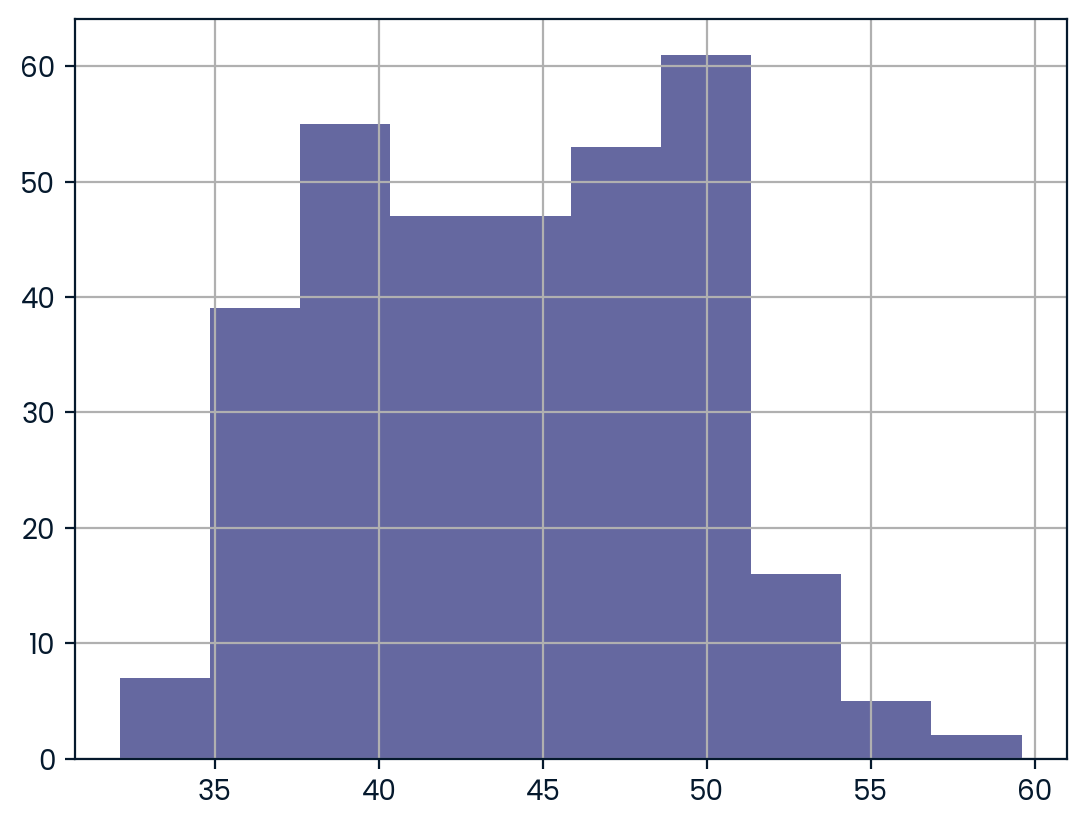

In [192]:
penguins_df['culmen_length_mm'].hist()
plt.show()

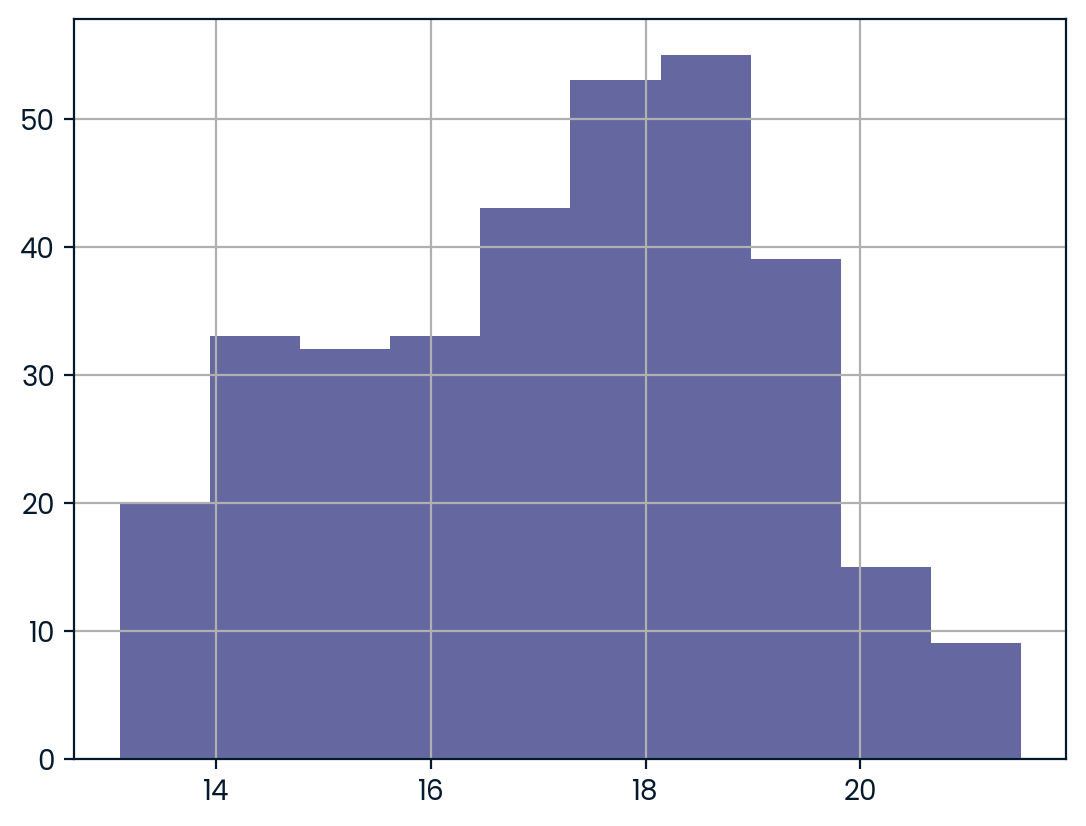

In [193]:
penguins_df['culmen_depth_mm'].hist()
plt.show()

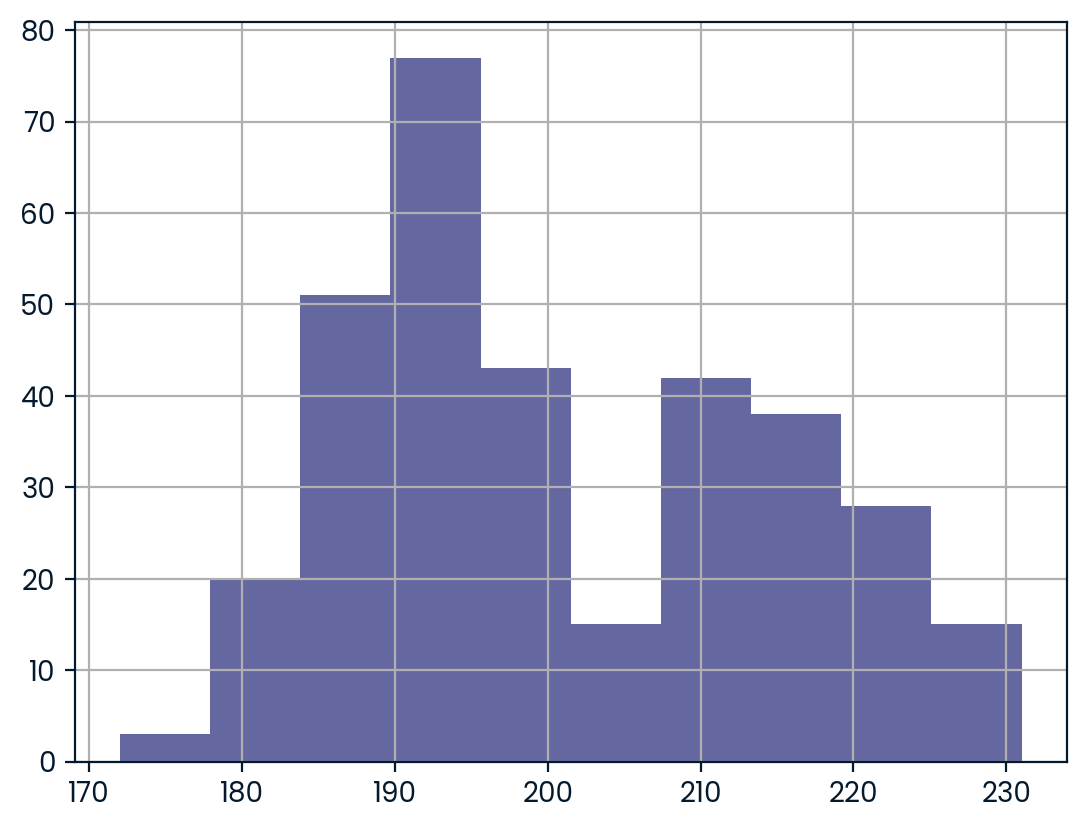

In [194]:
penguins_df['flipper_length_mm'].hist()
plt.show()

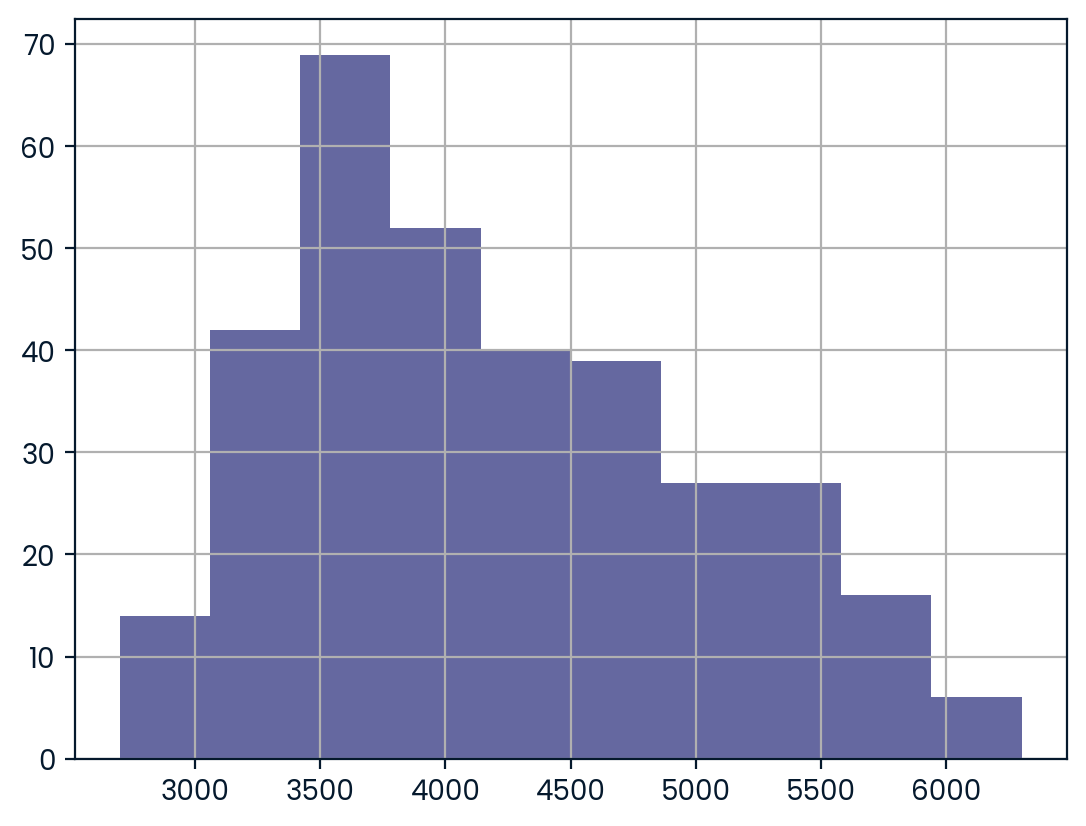

In [195]:
penguins_df['body_mass_g'].hist()
plt.show()

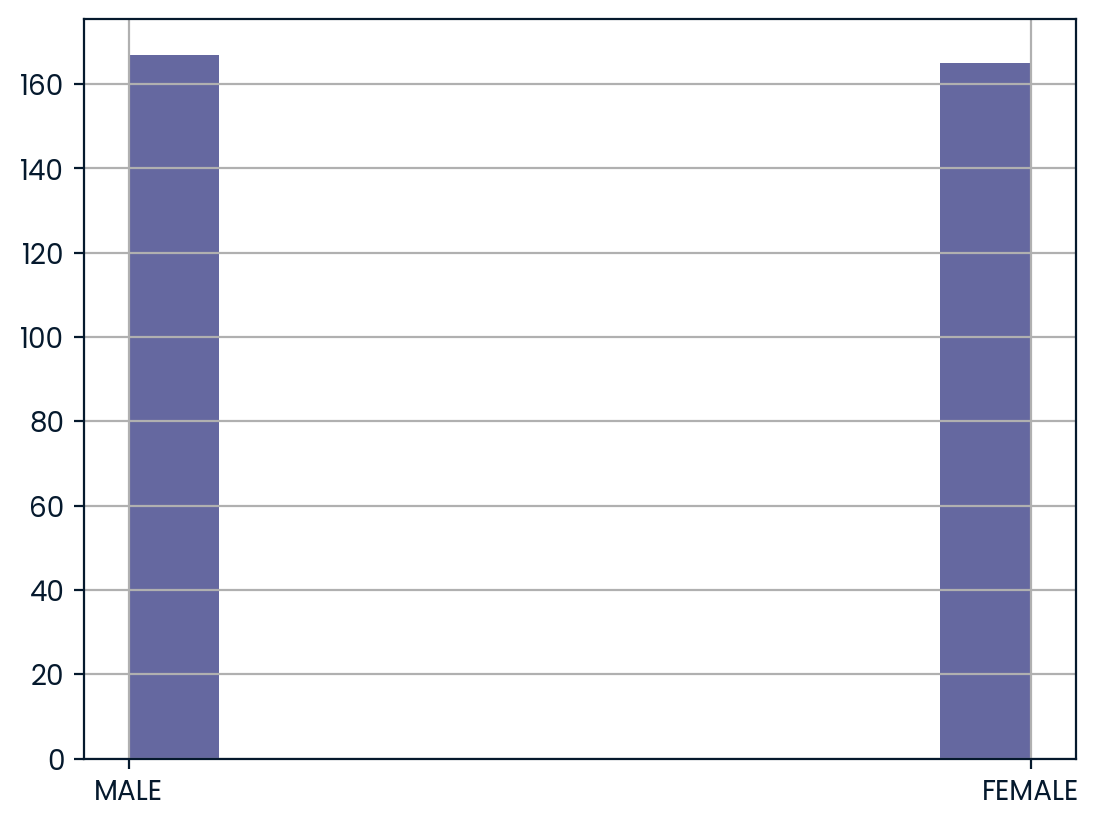

In [196]:
penguins_df['sex'].hist()
plt.show()

All attributes seem to be normally distributed. Now we're going to remove outliers using a 3 std cut-off.

In [197]:
penguins_df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


In [198]:
for col in penguins_df.columns:
    if penguins_df[col].dtype != 'object':
        mean = penguins_df[col].mean()
        std = penguins_df[col].std()
        cut_off = std * 3
        
        lower, upper = mean - cut_off, mean + cut_off
        penguins_df = penguins_df[(penguins_df[col] >= lower) & (penguins_df[col] <= upper)]

In [199]:
penguins_df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


There were no outliers detected with this method. Now we'll check the correlation matrix to see if there are any attributes we can remove.

In [200]:
penguins_df.corr()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.220570,0.654967,0.593396
culmen_depth_mm,-0.220570,1.000000,-0.580062,-0.476386
flipper_length_mm,0.654967,-0.580062,1.000000,0.873267
body_mass_g,0.593396,-0.476386,0.873267,1.000000


There are no strongly correlated attributes, so we keep all of them. Now we can proceed with preproccesing.
We will start with encoding the boolean attribute "sex".

In [201]:
penguins_df["sex"].replace("MALE", 1, inplace=True)
penguins_df["sex"].replace("FEMALE", 0, inplace=True)
penguins_df["sex"] = penguins_df["sex"].astype(int)

In [202]:
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,36.7,19.3,193.0,3450.0,0
4,39.3,20.6,190.0,3650.0,1


Now we can standarize the other attributes using the StandardScaler.

In [203]:
sc = StandardScaler()

penguins_scaled = penguins_df.copy()

for col in ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']:
    penguins_scaled[col] = sc.fit_transform(penguins_scaled[[col]])

In [204]:
penguins_scaled.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.903906,0.790360,-1.425342,-0.566948,1
1,-0.830434,0.126187,-1.068577,-0.504847,0
2,-0.683490,0.432728,-0.426399,-1.187953,0
3,-1.344738,1.096901,-0.569105,-0.939551,0
4,-0.867170,1.761074,-0.783164,-0.691149,1


Before running the KMeans algorithm we will use an elbow plot to determine the correct number of clusters.

In [205]:
dissortions = []
for i in range(1,10):
    k_means = KMeans(n_clusters=i, random_state=42).fit(penguins_scaled)
    dissortions.append(k_means.inertia_)

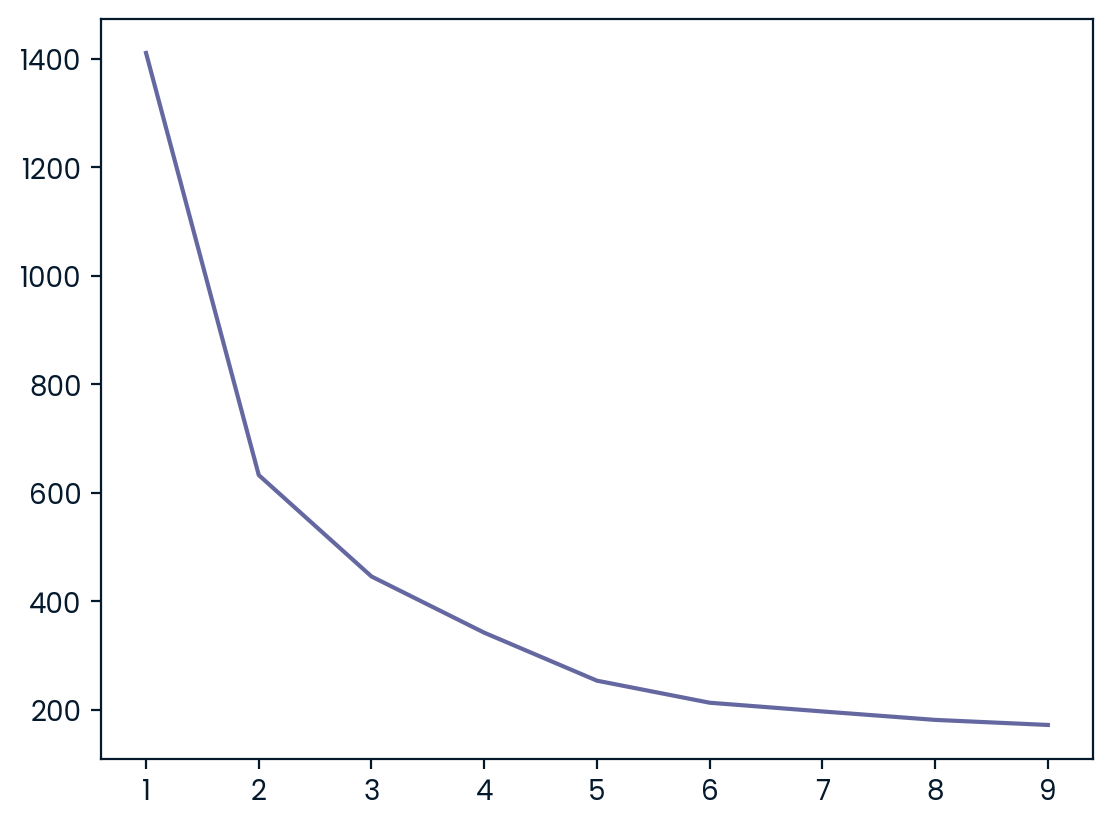

In [206]:
plt.plot(range(1,10), dissortions)
plt.show()

There doesn't seem to be a number where the inertia decreases slowly, but the problem does mention there are three species  of penguins, which aligns with the elbow plot.

In [207]:
k_means = KMeans(n_clusters = 3, random_state=42, n_init="auto").fit(penguins_scaled)

In [208]:
penguins_scaled['pred_species'] = k_means.labels_

In [209]:
penguins_scaled.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,pred_species
0,-0.903906,0.790360,-1.425342,-0.566948,1,2
1,-0.830434,0.126187,-1.068577,-0.504847,0,2
2,-0.683490,0.432728,-0.426399,-1.187953,0,2
3,-1.344738,1.096901,-0.569105,-0.939551,0,2
4,-0.867170,1.761074,-0.783164,-0.691149,1,2


In [210]:
stat_penguins = penguins_scaled.groupby("pred_species").mean()

Now we'll turn the standarized values to the original scale.

In [211]:
for col in ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']:
    sc.fit(penguins_df[[col]])
    stat_penguins[col] = sc.inverse_transform(stat_penguins[[col]])

In [212]:
stat_penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
pred_species,,,,,
0,47.075556,18.862222,197.266667,3944.722222,0.711111
1,47.568067,14.996639,217.235294,5092.436975,0.512605
2,38.354472,17.988618,187.959350,3540.853659,0.341463
